In [1]:
import os, sys

# 1) Put the env’s DLL folders first on PATH
prefix = sys.prefix
priority = [rf"{prefix}\Library\bin", rf"{prefix}\bin", rf"{prefix}\DLLs"]
rest = [p for p in os.environ["PATH"].split(os.pathsep)
        if not any(p.lower().startswith(x.lower()) for x in priority)]
# Optionally drop CUDA/Intel/VS paths that drag in other OpenMP runtimes:
drop_substrings = ("oneapi", "intel", "cuda", "nvidia", "microsoft visual studio")
rest = [p for p in rest if not any(s in p.lower() for s in drop_substrings)]
os.environ["PATH"] = os.pathsep.join(priority + rest)

# 2) Force single-threaded math (stability)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"   # harmless if you’re on OpenBLAS

In [2]:
import ctypes
for dll in ("libgomp-1.dll", "vcomp140.dll", "libiomp5md.dll"):
    try:
        ctypes.CDLL(dll); print("Loaded:", dll)
    except OSError as e:
        print("Missing:", dll)

Loaded: libgomp-1.dll
Loaded: vcomp140.dll
Loaded: libiomp5md.dll


In [3]:
import numpy as np, pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [4]:
import sys
import os
os.environ["OMP_NUM_THREADS"] = "1"   # set before importing numpy/xgboost
os.environ["MKL_NUM_THREADS"] = "1"

classes_path = os.path.abspath(r"D:\Repositories\PhD\src\classes")
src_path = os.path.abspath(r"D:\Repositories\PhD\src\functions")
sys.path.append(src_path)
sys.path.append(classes_path)
print(sys.path)

import hht_fe
import helpers

['d:\\Anaconda\\envs\\ml-cpu\\python311.zip', 'd:\\Anaconda\\envs\\ml-cpu\\DLLs', 'd:\\Anaconda\\envs\\ml-cpu\\Lib', 'd:\\Anaconda\\envs\\ml-cpu', '', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32\\lib', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\Pythonwin', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes']


In [5]:
import pandas as pd
import numpy as np

In [5]:
%xmode verbose
import faulthandler, sys
faulthandler.enable()
print(sys.getrecursionlimit())  # usually 1000

Exception reporting mode: Verbose
3000


In [6]:
def train_test_validate_model(X, y, feat_names = None):

    X_train, X_test, y_train, y_test = helpers.split_data(X, y, test_size = 0.25, random_state = 42, shuffle = True)
    y_train_pred, y_test_pred, model = helpers.train_and_predict_xgbc(X_train, y_train, X_test)
    roc_train, roc_test, test_thrs = helpers.calculate_roc((y_train, y_test), (y_train_pred, y_test_pred))
    best_thr = helpers.get_best_thr(roc_test[1], roc_test[0], test_thrs)
    y_test_pred_bin = np.where(y_test_pred >= best_thr, 1, 0)
    helpers.plot_roc(roc_train, roc_test, roc_bm = None)
    helpers.print_scores(y_test, y_test_pred_bin)

    if feat_names is not None:
        a = pd.Series(model.feature_importances_)
        b = pd.Series(feat_names)
        feat_importances = pd.concat((a, b), axis = 1)
    
    return model, feat_importances

In [92]:
def extract_features(X_healthy, X_faulty, fs, shuffle = True, win_s = 0.2, step_s=0.05, k_target=6):
    
    hht_fe_class = hht_fe.HHT_FeatureExtraction()

    if isinstance(X_healthy, pd.Series):
        X_healthy, names_healthy = hht_fe_class.windowed_hht_table(X_healthy.values, fs, win_s=win_s, step_s=step_s, k_target=k_target)
    else:
        X_healthy, names_healthy = hht_fe_class.windowed_hht_table(X_healthy, fs, win_s=win_s, step_s=step_s, k_target=k_target)
    df_healthy = pd.DataFrame(data=X_healthy, columns=names_healthy)
    if isinstance(X_faulty, pd.Series):
        X_faulty, names_faulty = hht_fe_class.windowed_hht_table(X_faulty.values, fs,win_s=win_s, step_s=step_s, k_target=k_target)
    elif isinstance(X_faulty, np.ndarray):
        X_faulty, names_faulty = hht_fe_class.windowed_hht_table(X_faulty, fs,win_s=win_s, step_s=step_s, k_target=k_target)
    df_faulty = pd.DataFrame(data=X_faulty, columns=names_faulty)

    df_healthy['fault'] = 0
    df_faulty['fault'] = 1

    df_overall = pd.concat((df_healthy,df_faulty))
    if shuffle:
        df_overall = df_overall.sample(frac = 1) # shuffle df

    return df_overall

In [31]:
def train_and_display_dtc(X, y, dominant_feature_name = None):

    dtc = DecisionTreeClassifier(random_state=42)

    if dominant_feature_name is not None:
        X = X[[dominant_feature_name]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

    dtc.fit(X_train, y_train)

    y_test_pred = dtc.predict(X_test)
    helpers.print_scores(y_test, y_test_pred)

    plt.figure(figsize=(12, 8))
    plot_tree(dtc, feature_names=X.columns, class_names=True, filled=True, max_depth=3)
    plt.tight_layout()
    plt.show()

# Electrical Motor

In [9]:
df = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1730_case_edu.csv")
df

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


In [10]:
df.columns.tolist()

['DE',
 'FE',
 'fault_diameter',
 'horse_power',
 'rounds_per_minute',
 'fault_end',
 'samples_per_second',
 'fault_element',
 'fault']

## 1730 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 7

In [11]:
de_healthy = df[(df['fault_end'] == 0) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 0) & (df['fault_diameter'] == 0)]['DE']
de_faulty = df[(df['fault_end'] == 1) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 1) & (df['fault_diameter'] == 7)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

(485643,)
(366988,)


In [12]:
df_features = extract_features(de_healthy, de_faulty, fs = 12000)
df_features

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak1_amp,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,fault
781,0.031905,3.284507,2.055338,0.046052,0.348479,0.043074,0.011276,0.062306,2068.836861,238.783820,...,142.000584,1035.0,18.447319,1065.0,12.254818,30.0,11.928891,1410.0,7.323798,0
548,0.033264,5.273170,2.566162,0.149421,0.348479,0.044999,0.012220,0.062821,2047.094346,276.139691,...,153.234860,1065.0,16.927393,1035.0,15.322931,30.0,13.097400,1040.0,10.835298,0
794,0.032751,3.810874,1.996752,-0.003978,0.349729,0.044845,0.011412,0.063433,2067.705857,244.302650,...,148.392375,1065.0,18.010337,1035.0,15.503663,30.0,13.729879,1040.0,8.847395,0
560,0.800514,3.800327,4.150181,0.025113,0.447270,0.973457,0.602436,2.257806,2689.784144,200.516508,...,2307.794077,105.0,444.434432,205.0,299.462362,150.0,285.124497,115.0,280.940891,1
113,0.032690,3.060371,1.898535,0.028733,0.349729,0.044849,0.011401,0.063685,2062.629924,252.873367,...,153.800181,1065.0,19.447919,1035.0,16.716217,1095.0,9.088907,55.0,8.810733,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,0.034277,4.211220,2.347135,0.042364,0.345144,0.046021,0.014587,0.068847,2017.334910,324.280215,...,148.686350,1035.0,19.730784,1065.0,12.395944,1040.0,10.498369,30.0,8.600092,0
569,0.032677,3.867022,2.199343,0.004310,0.348895,0.044337,0.013157,0.065762,2055.040333,273.443026,...,151.015709,1065.0,18.733227,1035.0,17.273471,30.0,10.988053,25.0,9.730744,0
591,0.032416,3.461274,1.912248,0.025124,0.349312,0.044422,0.011344,0.061380,2067.474848,250.563680,...,160.352612,1065.0,21.402579,1035.0,16.828726,1095.0,9.692070,50.0,8.224465,0
511,0.033623,3.562867,2.244333,0.060292,0.345977,0.045559,0.013816,0.065783,2020.926550,325.916549,...,155.824209,1065.0,21.031381,1035.0,16.092212,1010.0,9.327191,1095.0,8.202555,0


F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


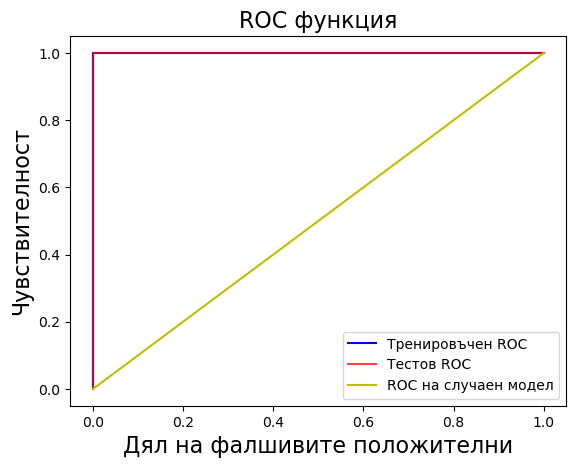

In [13]:
xgbc_1730_7, feat_importances = train_test_validate_model(X = df_features.iloc[:, :-1].values, y = df_features.iloc[:, -1].values, feat_names=df_features.columns.tolist())

In [14]:
feat_importances

,0,1
0,0.0,imf1_rms
1,0.0,imf1_crest
2,0.0,imf1_kurt
3,0.0,imf1_skew
4,1.0,imf1_zcr
...,...,...
81,0.0,env_peak4_freq
82,0.0,env_peak4_amp
83,0.0,env_peak5_freq
84,0.0,env_peak5_amp


This shows that a single feature is dominating

F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


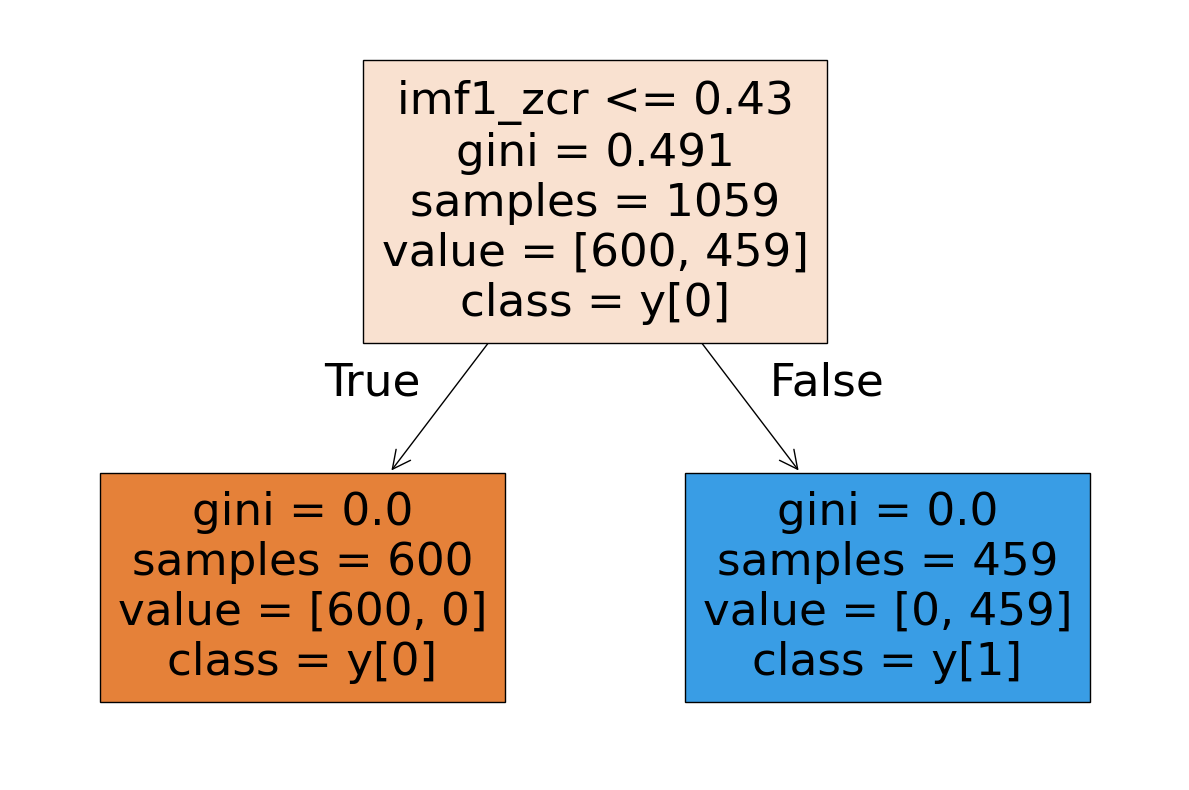

In [32]:
train_and_display_dtc(df_features.iloc[:, :-1], df_features.iloc[:, -1], dominant_feature_name = 'imf1_zcr')

Text(0.5, 1.0, 'Проверка на доминиращата х-ка')

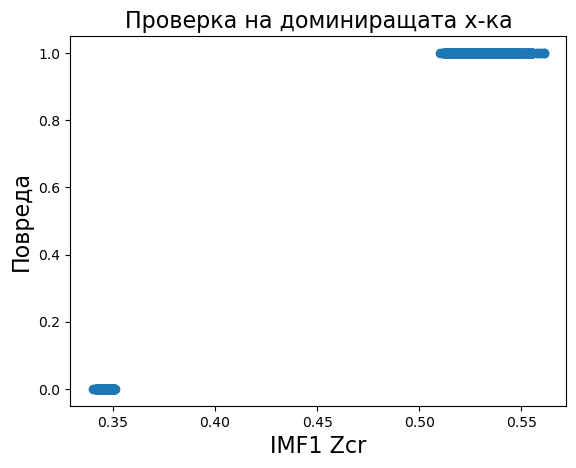

In [37]:
plt.scatter(df_features['imf1_zcr'], df_features['fault'])
plt.xlabel('IMF1 Zcr', fontsize = 16)
plt.ylabel('Повреда', fontsize = 16)
plt.title("Проверка на доминиращата х-ка", fontsize = 16)

## 1730 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 21

In [16]:
de_healthy = df[(df['fault_end'] == 0) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 0) & (df['fault_diameter'] == 0)]['DE']
de_faulty = df[(df['fault_end'] == 1) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 1) & (df['fault_diameter'] == 21)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

(485643,)
(365828,)


In [17]:
df_features = extract_features(de_healthy, de_faulty, fs = 12000)
df_features

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak1_amp,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,fault
173,0.032955,4.186440,2.095852,0.002226,0.347228,0.044953,0.011866,0.063829,2042.629592,295.480442,...,147.860460,1035.0,17.846813,1065.0,16.418207,30.0,11.280096,1040.0,8.464901,0
249,0.313985,8.115591,28.941338,0.002862,0.547311,0.216327,0.403061,1.048839,3209.846374,470.581680,...,545.957009,45.0,205.438275,30.0,201.133458,75.0,190.840544,105.0,142.690074,1
534,0.201347,5.166427,8.236960,0.013889,0.523551,0.206398,0.182612,0.577644,3013.547163,514.718593,...,659.447720,30.0,130.866516,105.0,104.051259,100.0,94.408554,75.0,87.657313,1
697,0.031753,2.962713,1.808856,0.007047,0.349312,0.043874,0.010277,0.059617,2072.356433,227.511094,...,153.005114,1065.0,19.002277,1035.0,15.382796,1095.0,10.592076,30.0,10.061914,0
373,0.034404,4.949890,2.843230,0.059665,0.346811,0.046268,0.015474,0.066938,2025.036934,311.483039,...,149.633254,30.0,17.681187,1065.0,16.245786,1035.0,14.442855,25.0,8.084532,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.032423,3.648280,1.993333,0.020479,0.348895,0.044302,0.011786,0.062996,2055.301252,266.180916,...,146.897678,1065.0,17.727468,1035.0,14.783870,30.0,10.310850,1040.0,9.917373,0
381,0.033720,3.476579,2.228322,0.051148,0.345977,0.045620,0.013919,0.065979,2021.163010,332.385538,...,155.577400,1065.0,19.190735,30.0,18.471870,1035.0,17.708580,1040.0,9.091771,0
701,0.034369,5.651368,2.921292,-0.072218,0.345977,0.045533,0.013680,0.067786,2025.956061,313.950367,...,144.939016,1035.0,15.742330,1065.0,14.356388,30.0,11.987837,1095.0,9.774947,0
566,0.179777,6.486257,7.339668,0.033465,0.513130,0.194164,0.164670,0.565141,2940.159005,552.552672,...,630.328047,105.0,86.815814,30.0,84.706305,45.0,76.695648,75.0,69.920641,1


F1: 0.994
Accuracy: 0.994
Precision: 1.000
ROC AUC: 0.994
Recall: 0.987


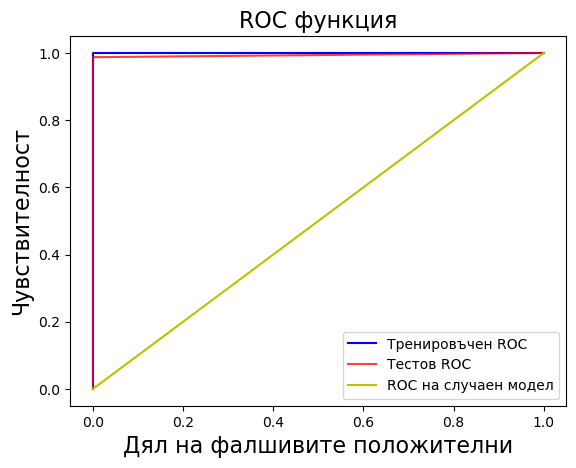

In [18]:
xgbc_1730_7, feat_importances = train_test_validate_model(X = df_features.iloc[:, :-1].values, y = df_features.iloc[:, -1].values, feat_names=df_features.columns.tolist())

In [21]:
feat_importances

,0,1
0,0.0,imf1_rms
1,0.0,imf1_crest
2,0.0,imf1_kurt
3,0.0,imf1_skew
4,1.0,imf1_zcr
...,...,...
81,0.0,env_peak4_freq
82,0.0,env_peak4_amp
83,0.0,env_peak5_freq
84,0.0,env_peak5_amp


F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


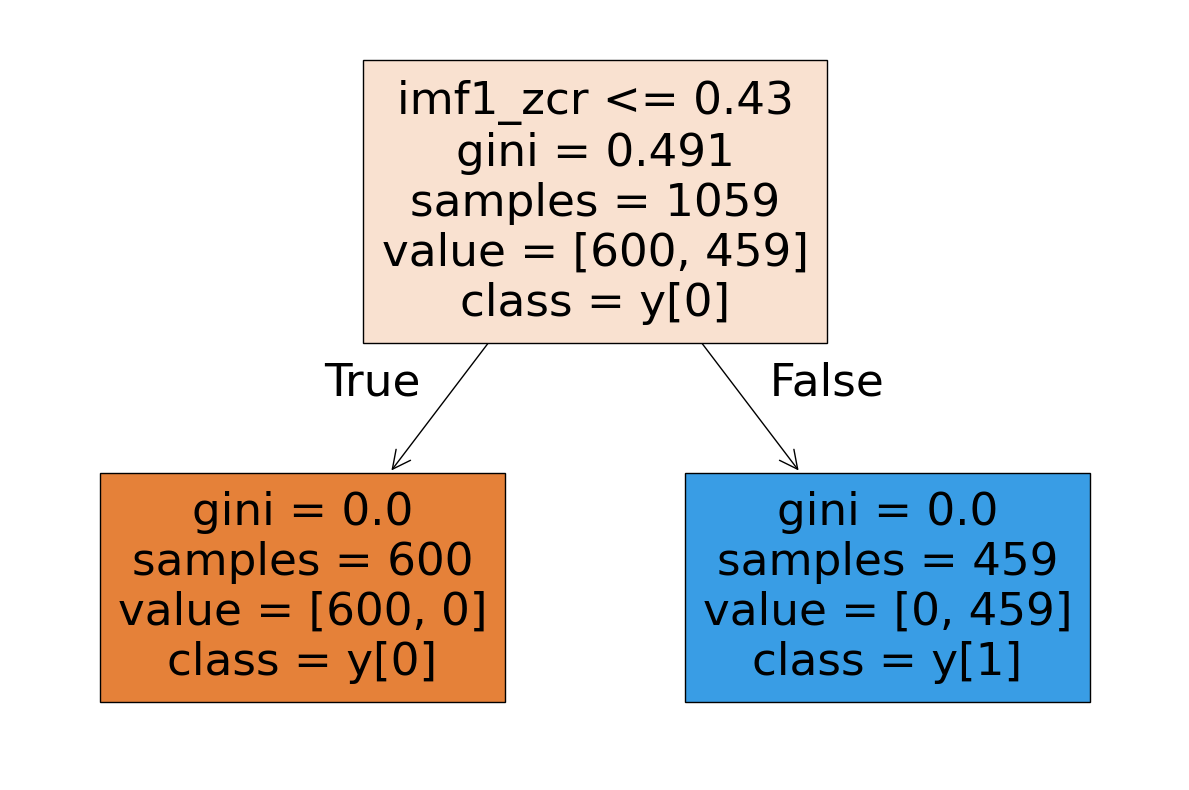

In [38]:
train_and_display_dtc(df_features.iloc[:, :-1], df_features.iloc[:, -1], dominant_feature_name='imf1_zcr')

## 1797 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 7

In [23]:
df_1797 = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1730_case_edu.csv")
df_1797

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


In [24]:
de_healthy = df_1797[(df_1797['fault_end'] == 0) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 0) & (df_1797['fault_diameter'] == 0)]['DE']
de_faulty = df_1797[(df_1797['fault_end'] == 1) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 1) & (df_1797['fault_diameter'] == 7)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

(485643,)
(366988,)


F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


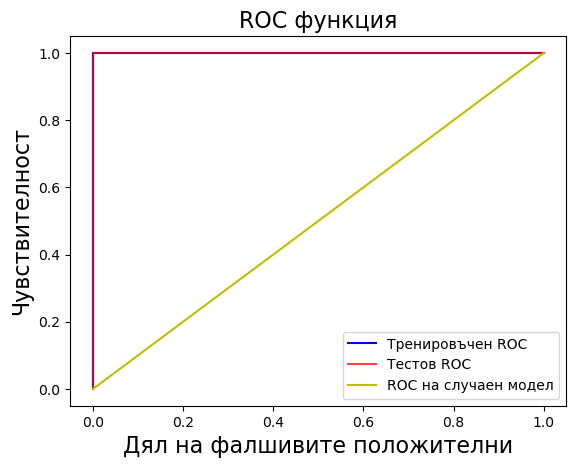

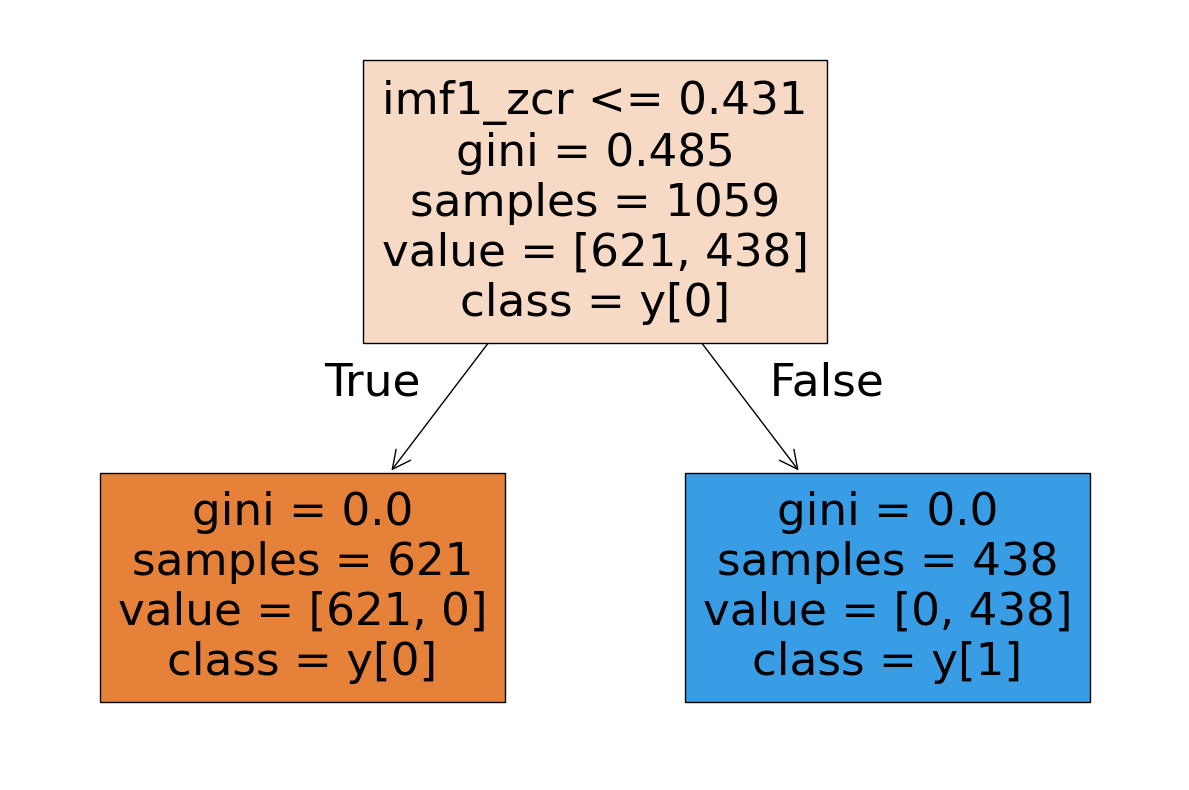

In [39]:
df_features = extract_features(de_healthy, de_faulty, fs = 12000)
xgbc_1797_7, feat_importances = train_test_validate_model(X = df_features.iloc[:, :-1].values, y = df_features.iloc[:, -1].values, feat_names=df_features.columns.tolist())
train_and_display_dtc(df_features.iloc[:, :-1], df_features.iloc[:, -1], dominant_feature_name='imf1_zcr')

In [45]:
feat_importances[feat_importances[0] == 1][1].reset_index(drop=True)[0]

'imf1_zcr'

## 1797 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 21

(485643,)
(365828,)
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


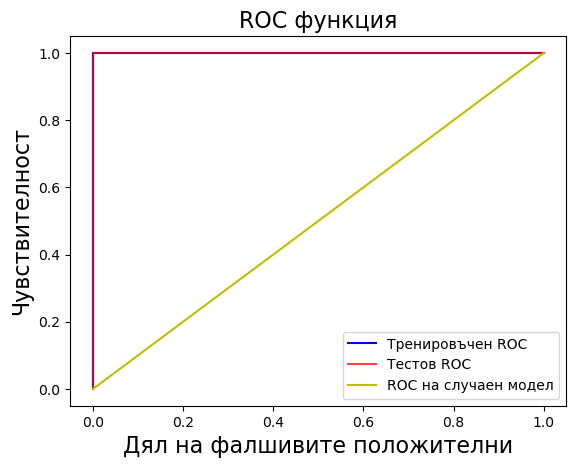

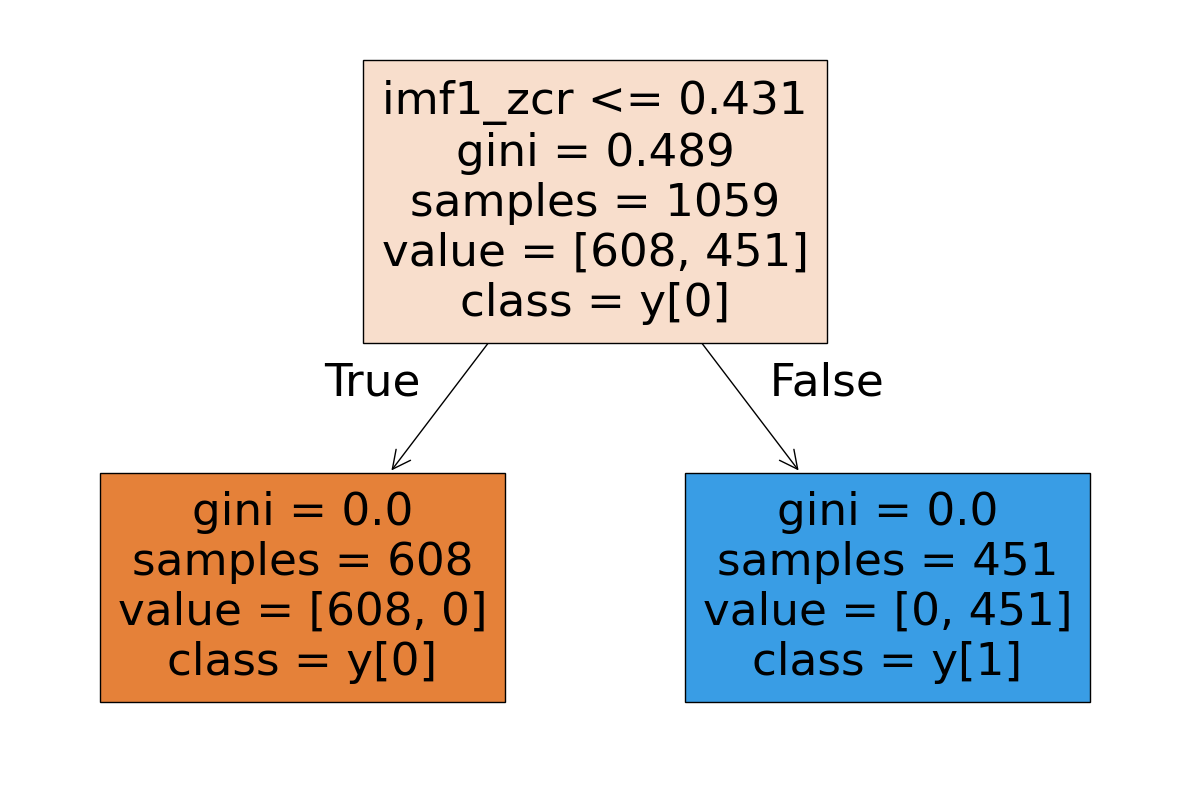

In [46]:
de_healthy = df_1797[(df_1797['fault_end'] == 0) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 0) & (df_1797['fault_diameter'] == 0)]['DE']
de_faulty = df_1797[(df_1797['fault_end'] == 1) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 1) & (df_1797['fault_diameter'] == 21)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

df_features = extract_features(de_healthy, de_faulty, fs = 12000)
xgbc_1797_7, feat_importances = train_test_validate_model(X = df_features.iloc[:, :-1].values, y = df_features.iloc[:, -1].values, feat_names=df_features.columns.tolist())
dom_f = feat_importances[feat_importances[0] == 1][1].reset_index(drop=True)[0]
train_and_display_dtc(df_features.iloc[:, :-1], df_features.iloc[:, -1], dominant_feature_name=dom_f)

In [28]:
feat_importances

,0,1
0,0.0,imf1_rms
1,0.0,imf1_crest
2,0.0,imf1_kurt
3,0.0,imf1_skew
4,1.0,imf1_zcr
...,...,...
81,0.0,env_peak4_freq
82,0.0,env_peak4_amp
83,0.0,env_peak5_freq
84,0.0,env_peak5_amp


# ICE

In [47]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

def process_ice_signal(signal):
    qt = QuantileTransformer(output_distribution='normal')
    sds = StandardScaler()
    return sds.fit_transform(qt.fit_transform(signal.values.reshape(-1, 1))).flatten()

In [48]:
df_ice = pd.read_csv(r"D:\Repositories\PhD\parsed_data\ICE_data\internal_combustion_engine_bearings_fixed_duplicates.csv")
df_ice

,Time,Demand 1,Control 1,Output Drive 1,Channel 1,Channel 2,Channel 3,Channel 4,Channel 1 Kurtosis,Channel 2 Kurtosis,...,Rear Input 5,Rear Input 6,Rear Input 7,Rear Input 8,FAULT,RPM,HUMIDITY%,TEMPERATURE_Celsius,resultant_vibration_magnitude,resultant_vibration_magnitude_normal_dist
0,0.001450,0.125011,0.176033,0.000000,0.211458,0.209182,0.145823,1.624200e-15,2.52457,2.94874,...,0,0,0,0,1,1000,0,-10,0.331264,-1.104839
1,0.006283,0.125011,0.176033,0.000012,0.206329,0.206513,0.150478,1.643320e-15,2.32290,2.46553,...,0,0,0,0,1,1000,0,-10,0.328425,-1.113447
2,0.009633,0.125011,0.172626,0.000013,0.206351,0.194663,0.148313,1.528270e-15,2.26458,2.55488,...,0,0,0,0,1,1000,0,-10,0.320111,-1.139087
3,0.013200,0.125011,0.172626,0.000014,0.214463,0.214489,0.155652,1.791370e-15,2.53380,2.66379,...,0,0,0,0,1,1000,0,-10,0.340921,-1.076103
4,0.016583,0.125011,0.172626,0.000015,0.210449,0.198857,0.154162,1.594310e-15,2.51443,2.81510,...,0,0,0,0,1,1000,0,-10,0.328023,-1.114673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390057,27.302300,0.500044,0.515140,0.043543,0.554265,0.560519,1.633510,1.712510e-15,3.10602,3.09644,...,0,0,0,0,0,2000,50,45,1.813766,0.595405
390058,27.305700,0.500044,0.515140,0.043541,0.554672,0.560996,1.646360,1.711110e-15,3.10423,3.09293,...,0,0,0,0,0,2000,50,45,1.825617,0.601918
390059,27.309200,0.500044,0.515140,0.043536,0.555249,0.561109,1.645410,1.710140e-15,3.11372,3.09118,...,0,0,0,0,0,2000,50,45,1.824971,0.601564
390060,27.312500,0.500044,0.515305,0.043532,0.555029,0.560672,1.640060,1.711640e-15,3.11269,3.09097,...,0,0,0,0,0,2000,50,45,1.819947,0.598807


## RPM = 1000; Humidity = 50%, Temperature = 30

In [93]:
c1_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 1'])
c1_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 1'])
c2_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 2'])
c2_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 2'])
c3_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 3'])
c3_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 3'])

print(c1_healthy.shape)
print(c1_faulty.shape)

print(c2_healthy.shape)
print(c2_faulty.shape)

print(c3_healthy.shape)
print(c3_faulty.shape)

(5264,)
(4535,)
(5264,)
(4535,)
(5264,)
(4535,)


Извличат се характеристики за трите канала

In [102]:
c1_feats = extract_features(c1_healthy, c1_faulty, fs = 3200, shuffle = False, win_s = 0.1, step_s=0.01)
c1_feats.columns = c1_feats.columns + '_c1'
c2_feats = extract_features(c2_healthy, c2_faulty, fs = 3200, shuffle = False, win_s = 0.1, step_s=0.01)
c2_feats.columns = c2_feats.columns + '_c2'
c3_feats = extract_features(c3_healthy, c3_faulty, fs = 3200, shuffle = False, win_s = 0.1, step_s=0.01)
c3_feats.columns = c3_feats.columns + '_c3'

In [103]:
ac_feats = pd.concat((c1_feats.reset_index(drop=True), c2_feats.reset_index(drop=True), c3_feats.reset_index(drop=True)), axis = 1)
ac_feats

,imf1_rms_c1,imf1_crest_c1,imf1_kurt_c1,imf1_skew_c1,imf1_zcr_c1,imf1_amp_mean_c1,imf1_amp_std_c1,imf1_amp_p95_c1,imf1_f_mean_c1,imf1_f_std_c1,...,env_peak1_amp_c3,env_peak2_freq_c3,env_peak2_amp_c3,env_peak3_freq_c3,env_peak3_amp_c3,env_peak4_freq_c3,env_peak4_amp_c3,env_peak5_freq_c3,env_peak5_amp_c3,fault_c3
0,0.192775,7.356755,26.101586,0.876726,0.633229,0.155339,0.241451,0.467238,910.351195,326.366119,...,632.609120,10.0,79.242167,20.0,27.641788,30.0,14.171958,40.0,13.342890,0
1,0.174424,8.119615,37.808668,1.176804,0.614420,0.131334,0.236734,0.440561,869.683036,333.502328,...,600.122017,10.0,61.920017,20.0,30.188948,30.0,25.396214,40.0,12.099330,0
2,0.071362,6.345823,13.358198,-0.405099,0.633229,0.067638,0.074941,0.220616,921.405658,314.221737,...,560.603476,10.0,37.792283,20.0,27.590167,60.0,20.083173,50.0,15.881956,0
3,0.048158,5.601800,9.624821,0.634484,0.623824,0.052960,0.036194,0.108096,868.391035,302.823329,...,526.072701,10.0,17.226106,40.0,8.902081,70.0,7.903254,60.0,6.852058,0
4,0.036360,3.041648,2.800217,0.041461,0.636364,0.047906,0.025615,0.095364,934.098621,281.545427,...,521.681820,10.0,15.921881,50.0,15.765425,30.0,14.644251,20.0,13.378223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,0.441817,7.011259,22.671558,-1.079520,0.623824,0.329379,0.662149,2.023399,636.190622,362.866931,...,437.106431,10.0,57.509351,20.0,14.042660,50.0,10.855811,80.0,7.940262,1
283,0.433868,7.277243,24.152588,-0.689742,0.614420,0.325763,0.652072,1.939549,618.921895,361.802862,...,411.833934,10.0,50.371403,20.0,19.582213,40.0,11.256580,60.0,10.101359,1
284,0.438368,7.066431,23.403741,-1.098283,0.620690,0.330322,0.683110,2.070024,621.670276,363.154007,...,375.236451,10.0,36.242296,30.0,32.378424,20.0,31.110599,50.0,19.488782,1
285,0.430697,7.351257,24.635295,-0.470800,0.598746,0.270392,0.621293,1.667131,620.518564,381.593426,...,343.599566,20.0,44.386595,10.0,26.533331,30.0,11.799873,40.0,4.054399,1


In [104]:
ac_feats['fault'] = (ac_feats['fault_c1'] & ac_feats['fault_c2'] & ac_feats['fault_c3'])

In [105]:
ac_feats = ac_feats.sample(frac = 1)
ac_feats

,imf1_rms_c1,imf1_crest_c1,imf1_kurt_c1,imf1_skew_c1,imf1_zcr_c1,imf1_amp_mean_c1,imf1_amp_std_c1,imf1_amp_p95_c1,imf1_f_mean_c1,imf1_f_std_c1,...,env_peak2_freq_c3,env_peak2_amp_c3,env_peak3_freq_c3,env_peak3_amp_c3,env_peak4_freq_c3,env_peak4_amp_c3,env_peak5_freq_c3,env_peak5_amp_c3,fault_c3,fault
36,0.046579,3.691635,3.418902,-0.079773,0.586207,0.062965,0.033848,0.122002,782.667560,313.802650,...,10.0,18.612416,50.0,9.044937,40.0,8.768726,20.0,5.578614,0,0
86,0.061581,3.387624,3.282898,-0.001427,0.611285,0.083647,0.044094,0.180595,796.118843,313.490231,...,20.0,29.981892,10.0,19.015565,50.0,15.123642,70.0,8.495975,0,0
23,0.087987,5.532792,12.214346,-0.281814,0.608150,0.083253,0.096669,0.260862,846.919927,333.317709,...,10.0,18.273648,20.0,9.791931,30.0,7.268318,40.0,6.197143,0,0
64,0.054520,2.708139,2.417527,0.021295,0.611285,0.070837,0.035580,0.144060,890.725569,359.628532,...,10.0,10.747983,20.0,9.133201,130.0,6.631529,70.0,6.522418,0,0
251,0.045418,3.933250,4.235198,-0.040911,0.589342,0.057586,0.038350,0.131887,736.248556,303.612411,...,10.0,27.951443,20.0,20.278601,30.0,15.908762,40.0,11.545850,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,0.065678,6.682746,9.108487,-0.922059,0.652038,0.079788,0.046944,0.169338,854.938214,327.955318,...,10.0,15.357321,30.0,13.260123,20.0,12.860863,50.0,6.054716,0,0
152,0.050586,3.879033,4.247225,0.463798,0.605016,0.067452,0.040213,0.158776,750.565123,359.568724,...,10.0,32.095327,20.0,25.363681,30.0,17.323331,40.0,13.628789,0,0
170,0.035277,6.087633,14.651438,1.244556,0.570533,0.032845,0.032792,0.088124,806.710608,309.910442,...,60.0,18.648374,10.0,17.041851,20.0,14.627366,50.0,13.738272,1,1
238,0.032586,7.590263,19.722491,-2.341053,0.595611,0.033373,0.024926,0.078934,763.703109,314.991932,...,10.0,66.675204,30.0,27.928033,20.0,26.801092,50.0,20.514905,1,1


In [74]:
ac_feats.drop(['fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1)

,imf1_rms_c1,imf1_crest_c1,imf1_kurt_c1,imf1_skew_c1,imf1_zcr_c1,imf1_amp_mean_c1,imf1_amp_std_c1,imf1_amp_p95_c1,imf1_f_mean_c1,imf1_f_std_c1,...,env_peak1_freq_c3,env_peak1_amp_c3,env_peak2_freq_c3,env_peak2_amp_c3,env_peak3_freq_c3,env_peak3_amp_c3,env_peak4_freq_c3,env_peak4_amp_c3,env_peak5_freq_c3,env_peak5_amp_c3
36,0.040804,4.280355,3.840765,0.171241,0.600939,0.052580,0.032296,0.116568,785.658076,330.030116,...,0.0,526.488365,15.0,79.678147,5.0,67.924261,10.0,53.423560,20.0,25.176839
46,0.039681,4.501865,4.460185,-0.018147,0.604069,0.049739,0.034053,0.115435,774.912013,310.381493,...,0.0,258.634279,5.0,62.806190,10.0,48.284517,20.0,32.489845,15.0,13.269909
35,0.046570,3.750360,3.476556,0.077490,0.602504,0.060715,0.035521,0.130368,791.057780,335.930748,...,0.0,184.065176,45.0,22.527251,35.0,18.532634,25.0,16.791801,15.0,13.087268
33,0.040218,4.088300,4.904081,0.024836,0.597809,0.046962,0.031699,0.111519,808.558317,323.011715,...,0.0,269.201250,5.0,29.743943,20.0,29.621531,25.0,28.394640,40.0,27.589301
6,0.049151,4.231101,4.399574,0.319806,0.604069,0.058646,0.041783,0.134516,821.238423,321.284207,...,0.0,95.600482,5.0,15.110416,55.0,13.592672,65.0,10.215897,60.0,9.369795
15,0.054765,3.934519,3.796422,0.008145,0.608764,0.070096,0.040756,0.153509,802.913508,331.106083,...,0.0,285.982956,5.0,89.256837,25.0,23.283860,30.0,15.046945,10.0,12.373157
12,0.047885,3.109030,2.775281,0.049882,0.611894,0.063183,0.033531,0.129096,864.591071,347.018846,...,0.0,232.516860,25.0,39.012978,10.0,29.380473,15.0,25.781910,40.0,25.433959
52,0.314061,9.781734,44.067998,-1.816980,0.588419,0.192574,0.468551,0.739039,647.352859,353.474070,...,0.0,712.838255,5.0,223.578997,15.0,82.763064,25.0,48.386182,35.0,41.843162
10,0.055770,4.319847,4.013603,-0.079170,0.640063,0.069758,0.042336,0.149698,883.941210,326.471528,...,0.0,197.338881,35.0,30.284177,30.0,20.809480,25.0,19.781070,20.0,19.408341
30,0.129073,7.112039,16.776544,-0.060503,0.560250,0.109549,0.170004,0.500639,650.171904,393.606941,...,0.0,230.336847,5.0,127.786271,10.0,101.848147,15.0,87.758597,20.0,69.229324


F1: 0.986
Accuracy: 0.986
Precision: 0.972
ROC AUC: 0.986
Recall: 1.000


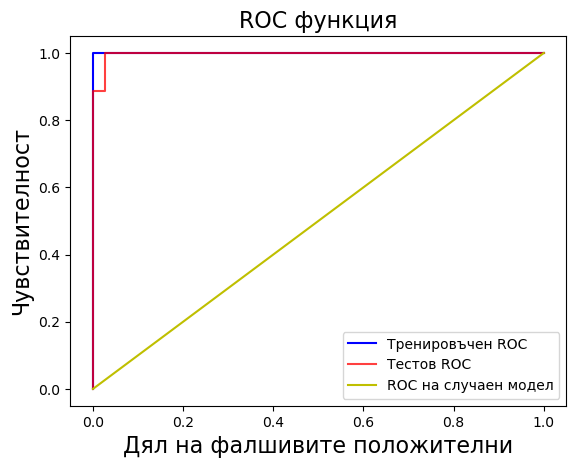

In [106]:
xgbc_ice_1000, feat_importances = train_test_validate_model(ac_feats.drop(['fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1), ac_feats['fault'], feat_names = ac_feats.drop(['fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1).columns)

In [120]:
feat_importances[feat_importances[0] != 0].sort_values(0, ascending=False).sort_values(0, ascending=False)

,0,1
6,0.264607,imf1_amp_std_c1
5,0.205180,imf1_amp_mean_c1
76,0.101236,env_peak1_amp_c1
18,0.089585,imf2_amp_std_c1
179,0.045482,imf1_f_std_c3
191,0.026093,imf2_f_std_c3
15,0.025151,imf2_skew_c1
29,0.024891,imf3_amp_mean_c1
183,0.024485,imf2_crest_c3
19,0.022789,imf2_amp_p95_c1


F1: 0.925
Accuracy: 0.931
Precision: 0.969
ROC AUC: 0.929
Recall: 0.886


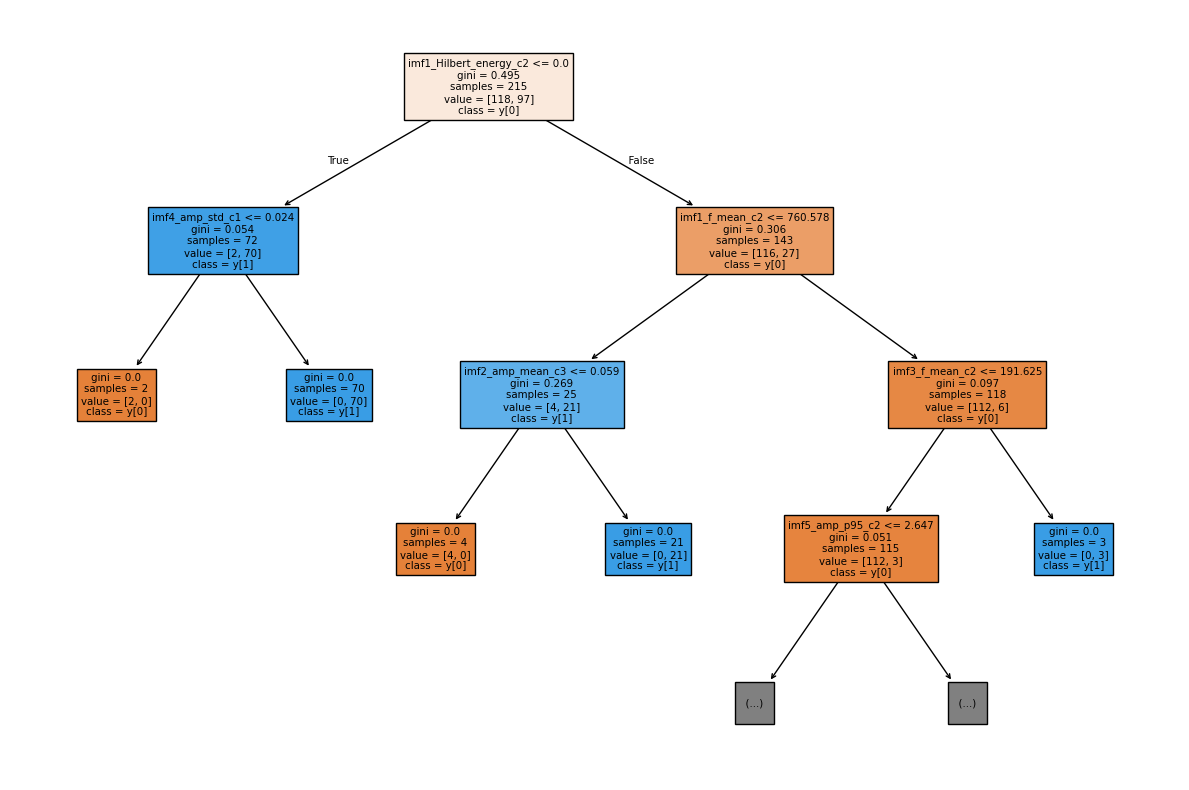

In [108]:
train_and_display_dtc(ac_feats.drop(['fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1), ac_feats['fault'])

## RPM = 1500; Humidity = 50%, Temperature = 30

(1513,)
(1778,)
(1513,)
(1778,)
(1513,)
(1778,)
(84, 259)
F1: 0.963
Accuracy: 0.952
Precision: 0.929
ROC AUC: 0.938
Recall: 1.000
F1: 0.762
Accuracy: 0.762
Precision: 1.000
ROC AUC: 0.808
Recall: 0.615


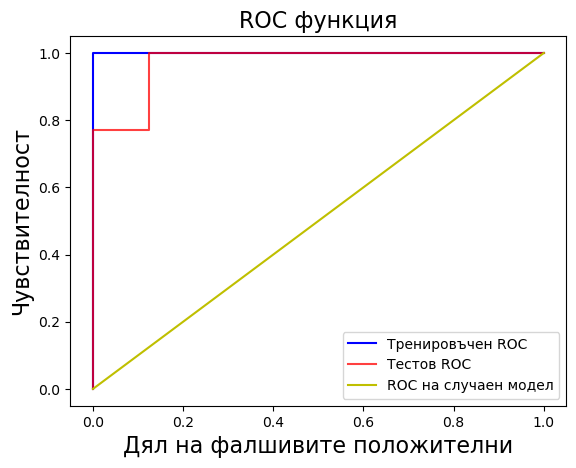

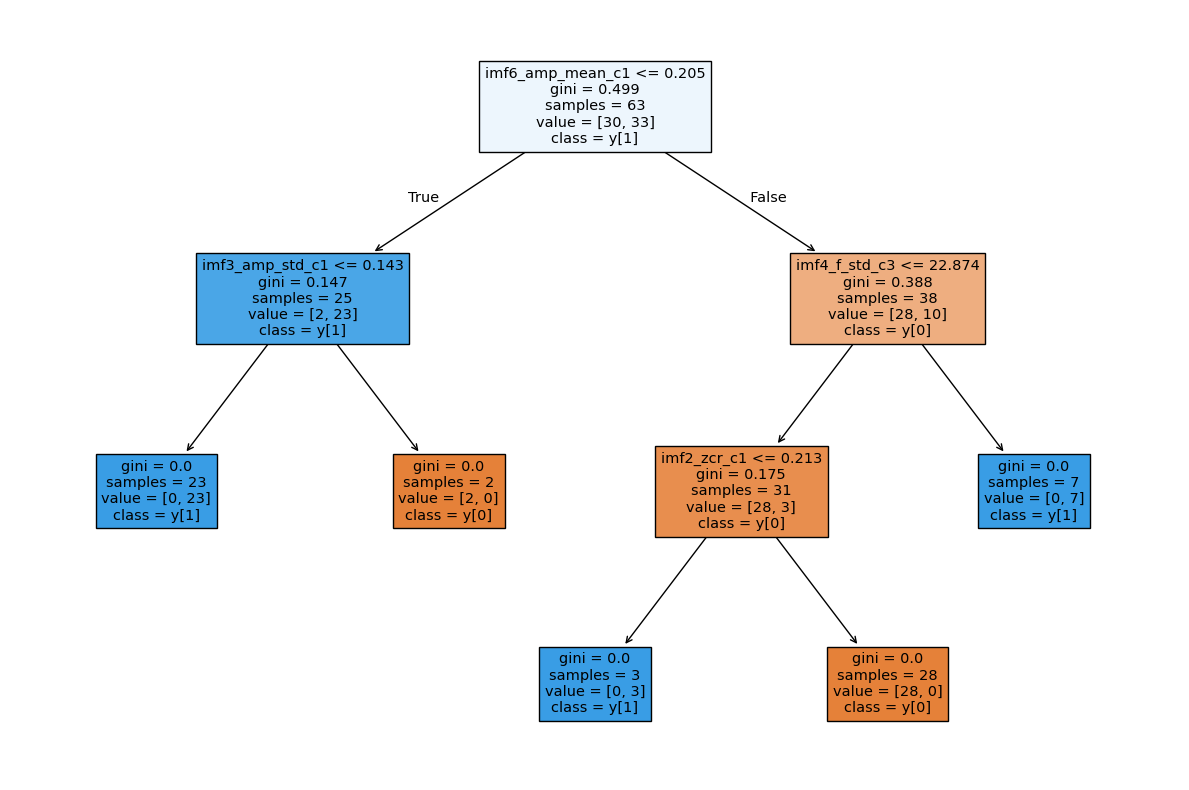

In [112]:
c1_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 1'])
c1_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 1'])
c2_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 2'])
c2_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 2'])
c3_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 3'])
c3_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 3'])

print(c1_healthy.shape)
print(c1_faulty.shape)

print(c2_healthy.shape)
print(c2_faulty.shape)

print(c3_healthy.shape)
print(c3_faulty.shape)

c1_feats = extract_features(c1_healthy, c1_faulty, fs = 3200, shuffle = False, win_s = 0.1, step_s=0.01)
c1_feats.columns = c1_feats.columns + '_c1'
c2_feats = extract_features(c2_healthy, c2_faulty, fs = 3200, shuffle = False, win_s = 0.1, step_s=0.01)
c2_feats.columns = c2_feats.columns + '_c2'
c3_feats = extract_features(c3_healthy, c3_faulty, fs = 3200, shuffle = False, win_s = 0.1, step_s=0.01)
c3_feats.columns = c3_feats.columns + '_c3'

ac_feats = pd.concat((c1_feats.reset_index(drop=True), c2_feats.reset_index(drop=True), c3_feats.reset_index(drop=True)), axis = 1)
ac_feats['fault'] = (ac_feats['fault_c1'] & ac_feats['fault_c2'] & ac_feats['fault_c3'])
ac_feats = ac_feats.sample(frac = 1)
print(ac_feats.shape)

xgbc_ice_1500, feat_importances = train_test_validate_model(ac_feats.drop(['fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1), ac_feats['fault'], feat_names = ac_feats.drop(['fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1).columns)
train_and_display_dtc(ac_feats.drop(['fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1), ac_feats['fault'])

In [118]:
feat_importances[feat_importances[0] != 0].sort_values(0, ascending=False)

,0,1
6,0.264607,imf1_amp_std_c1
5,0.205180,imf1_amp_mean_c1
76,0.101236,env_peak1_amp_c1
18,0.089585,imf2_amp_std_c1
179,0.045482,imf1_f_std_c3
191,0.026093,imf2_f_std_c3
15,0.025151,imf2_skew_c1
29,0.024891,imf3_amp_mean_c1
183,0.024485,imf2_crest_c3
19,0.022789,imf2_amp_p95_c1


## RPM = 2000; Humidity = 50%, Temperature = 30

(8276,)
(3615,)
(8276,)
(3615,)
(8276,)
(3615,)
(352, 259)
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000
F1: 0.929
Accuracy: 0.955
Precision: 0.929
ROC AUC: 0.948
Recall: 0.929


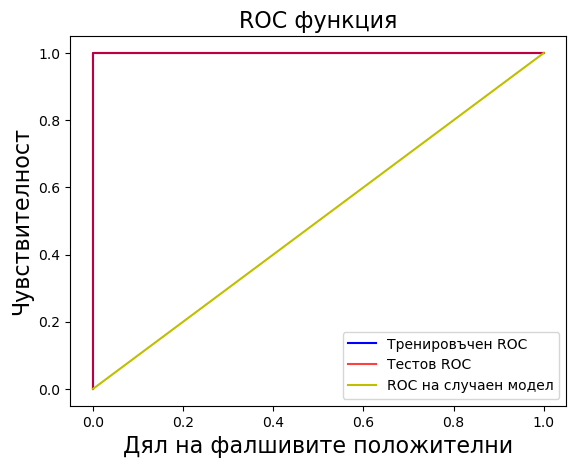

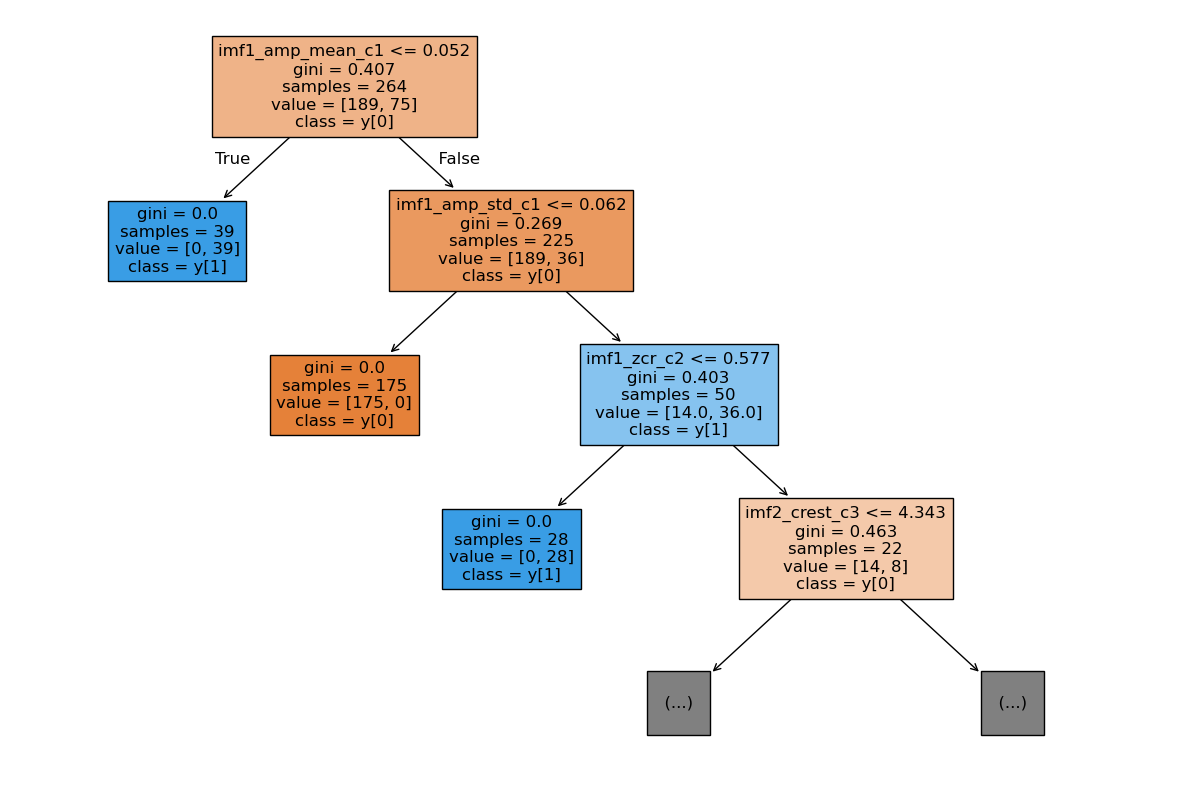

In [114]:
c1_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 1'])
c1_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 1'])
c2_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 2'])
c2_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 2'])
c3_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 3'])
c3_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 3'])

print(c1_healthy.shape)
print(c1_faulty.shape)

print(c2_healthy.shape)
print(c2_faulty.shape)

print(c3_healthy.shape)
print(c3_faulty.shape)

c1_feats = extract_features(c1_healthy, c1_faulty, fs = 3200, shuffle = False, win_s = 0.1, step_s=0.01)
c1_feats.columns = c1_feats.columns + '_c1'
c2_feats = extract_features(c2_healthy, c2_faulty, fs = 3200, shuffle = False, win_s = 0.1, step_s=0.01)
c2_feats.columns = c2_feats.columns + '_c2'
c3_feats = extract_features(c3_healthy, c3_faulty, fs = 3200, shuffle = False, win_s = 0.1, step_s=0.01)
c3_feats.columns = c3_feats.columns + '_c3'

ac_feats = pd.concat((c1_feats.reset_index(drop=True), c2_feats.reset_index(drop=True), c3_feats.reset_index(drop=True)), axis = 1)
ac_feats['fault'] = (ac_feats['fault_c1'] & ac_feats['fault_c2'] & ac_feats['fault_c3'])
ac_feats = ac_feats.sample(frac = 1)
print(ac_feats.shape)

xgbc_ice_1500, feat_importances = train_test_validate_model(ac_feats.drop(['fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1), ac_feats['fault'], feat_names = ac_feats.drop(['fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1).columns)
train_and_display_dtc(ac_feats.drop(['fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1), ac_feats['fault'])

In [117]:
feat_importances[feat_importances[0] != 0].sort_values(0, ascending=False)

,0,1
6,0.264607,imf1_amp_std_c1
5,0.205180,imf1_amp_mean_c1
76,0.101236,env_peak1_amp_c1
18,0.089585,imf2_amp_std_c1
179,0.045482,imf1_f_std_c3
191,0.026093,imf2_f_std_c3
15,0.025151,imf2_skew_c1
29,0.024891,imf3_amp_mean_c1
183,0.024485,imf2_crest_c3
19,0.022789,imf2_amp_p95_c1
